# ssp.train.py

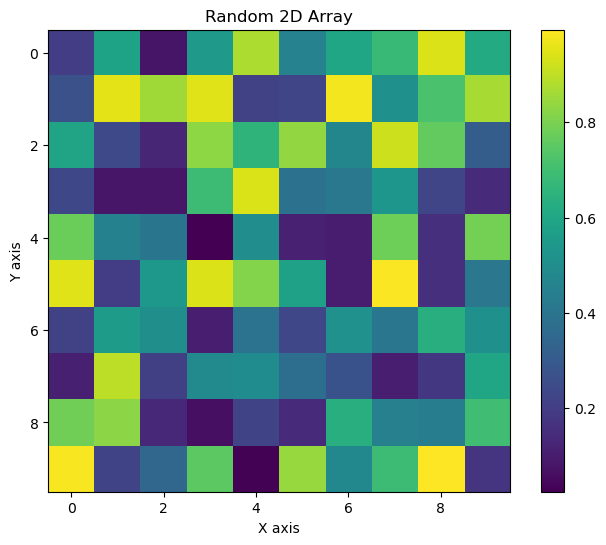

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from scipy import io
import itertools
import math
import datetime
import wandb
import pickle

# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈

In [2]:
def cluster_train_system( 
    gpu = 3,
    Conv_net = True,
    SAE_net = True,

    # hyperparameter
    dataset_num = 16,
    spike_length = 50,
    num_cluster = 4,  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
    training_cycle = 2400, # 그 초기 몇개까지만 cluster update할지


    batch_size = 32,
    max_epoch = 7000,
    learning_rate = 0.001,
    normalize_on = False, # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
    need_bias = False,
    # first_layer_no_train = False
    lif_add_at_first = False,
    my_seed = 42,

    TIME = 10, # SAE일 때만 유효
    v_decay = 0.5,
    v_threshold = 0.5,
    v_reset = 10000.0, # 10000이상 일 시 hard reset
    BPTT_on = True,

    SAE_hidden_nomean = True,
    current_time = '20250101_210938_786',

    optimizer = 'Adam',
    ):
    
    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    print(hyperparameters)
    ######################################################################################

    
    wandb.config.update(hyperparameters)
    wandb.run.name = f'{current_time}_SAE_net_{SAE_net}_v_threshold_{v_threshold}'
    wandb.define_metric("best_mean_cluster_accuracy_post_training_cycle_all_dataset2", summary="max")

    my_path_ground_BH = '/data2/spike_sorting/quiroga/BH/'


    filename = ["C_Easy1_noise005.mat", "C_Easy1_noise01.mat", "C_Easy1_noise015.mat", "C_Easy1_noise02.mat",
                "C_Easy2_noise005.mat", "C_Easy2_noise01.mat", "C_Easy2_noise015.mat", "C_Easy2_noise02.mat",
                "C_Difficult1_noise005.mat", "C_Difficult1_noise01.mat", "C_Difficult1_noise015.mat", "C_Difficult1_noise02.mat",
                "C_Difficult2_noise005.mat", "C_Difficult2_noise01.mat", "C_Difficult2_noise015.mat", "C_Difficult2_noise02.mat"]


    spike_tot = ["BH_Spike_e1n005.npy", "BH_Spike_e1n010.npy", "BH_Spike_e1n015.npy", "BH_Spike_e1n020.npy",
                "BH_Spike_e2n005.npy", "BH_Spike_e2n010.npy", "BH_Spike_e2n015.npy", "BH_Spike_e2n020.npy",
                "BH_Spike_d1n005.npy", "BH_Spike_d1n010.npy", "BH_Spike_d1n015.npy", "BH_Spike_d1n020.npy",
                "BH_Spike_d2n005.npy", "BH_Spike_d2n010.npy", "BH_Spike_d2n015.npy", "BH_Spike_d2n020.npy"]

    label_tot = ["BH_Label_e1n005.npy", "BH_Label_e1n010.npy", "BH_Label_e1n015.npy", "BH_Label_e1n020.npy",
                "BH_Label_e2n005.npy", "BH_Label_e2n010.npy", "BH_Label_e2n015.npy", "BH_Label_e2n020.npy",
                "BH_Label_d1n005.npy", "BH_Label_d1n010.npy", "BH_Label_d1n015.npy", "BH_Label_d1n020.npy",
                "BH_Label_d2n005.npy", "BH_Label_d2n010.npy", "BH_Label_d2n015.npy", "BH_Label_d2n020.npy"]

    template =  ["BH_Spike_TEMPLATE_e1n005.npy", "BH_Spike_TEMPLATE_e1n010.npy", "BH_Spike_TEMPLATE_e1n015.npy", "BH_Spike_TEMPLATE_e1n020.npy",
                "BH_Spike_TEMPLATE_e2n005.npy", "BH_Spike_TEMPLATE_e2n010.npy", "BH_Spike_TEMPLATE_e2n015.npy", "BH_Spike_TEMPLATE_e2n020.npy",
                "BH_Spike_TEMPLATE_d1n005.npy", "BH_Spike_TEMPLATE_d1n010.npy", "BH_Spike_TEMPLATE_d1n015.npy", "BH_Spike_TEMPLATE_d1n020.npy",
                "BH_Spike_TEMPLATE_d2n005.npy", "BH_Spike_TEMPLATE_d2n010.npy", "BH_Spike_TEMPLATE_d2n015.npy", "BH_Spike_TEMPLATE_d2n020.npy"]

    AE_train_path_gt_detect = 'BH_quiroga_training_dataset_gt_detect.pt' 
    AE_test_path_gt_detect = 'BH_quiroga_test_dataset_gt_detect.pt'

    AE_train_path_real_detect = 'BH_quiroga_training_dataset_real_detect.pt'
    AE_test_path_real_detect = 'BH_quiroga_test_dataset_real_detect.pt'

    AE_train_data = AE_train_path_real_detect #AE_train_path_gt_detect #AE_train_path_real_detect
    AE_test_data = AE_test_path_real_detect #AE_test_path_gt_detect  #AE_test_path_real_detect

    # thr_tot = np.array([0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7])
    cos_thr = np.array([0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.85, 0.95, 0.9, 0.8, 0.95, 0.95, 0.95, 0.95, 0.8])


    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= f'{gpu}'

    n_sample = spike_length

    seed_assign(my_seed)

    class spikedataset(Dataset):
        def __init__(self, path, transform = None):    
            self.transform = transform
            self.spike = torch.load(path)
            
        def __getitem__(self, index):
            spike = self.spike[index]            
            if self.transform is not None:
                spike = self.transform(spike)
            return spike
        
        def __len__(self):
            return len(self.spike)

    train_dataset = spikedataset(my_path_ground_BH + AE_train_data)
    train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

    test_dataset = spikedataset(my_path_ground_BH + AE_test_data)
    test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)



    # 모델 초기화
    if SAE_net == False:
        if Conv_net == True:
            net = Autoencoder_conv1(input_channels=1, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = 4, padding = 0, stride = 2, kernel_size = 3, need_bias=need_bias)
            net = torch.nn.DataParallel(net)
        else:
            net = Autoencoder_only_FC(encoder_ch=[96, 64, 32, 4], decoder_ch=[32,64,96,n_sample], n_sample=n_sample, need_bias=need_bias)
            net = torch.nn.DataParallel(net)
    else:
        if Conv_net == True: 
            net = SAE_conv1(input_channels=1, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = 4, padding = 0, stride = 2, kernel_size = 3, 
                                synapse_fc_trace_const1=1, 
                                synapse_fc_trace_const2=v_decay, #안씀 
                                TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first)
            net = torch.nn.DataParallel(net)
        else:
            net = SAE_fc_only(encoder_ch=[96, 64, 32, 4], 
                                decoder_ch=[32,64,96,n_sample], 
                                in_channels=n_sample, # in_channel 이 여기선 걍 lenght.
                                synapse_fc_trace_const1=1,
                                synapse_fc_trace_const2=v_decay,  #안씀 
                                TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first)
            net = torch.nn.DataParallel(net)

    # net = torch.load('/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_AE_re_e7000.pth')
    # net = torch.load('/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_20250101_210938_786.pth')
    # load했으면 torch.nn.DataParallel 하지마





    wandb.watch(net, log="all", log_freq = 10)









    if SAE_net == True:
        assert 'SAE' in net.module.__class__.__name__

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    net = net.to(device)
    print(net)
    print('Device:',device)

    criterion = nn.MSELoss()
    
    if optimizer == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    elif optimizer == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum = 0.9)
    else:
        assert False, 'optimizer를 잘못 입력했습니다.'
        
    loss_history = []
    mean_cluster_accuracy_during_training_cycle_all_dataset_history = []
    mean_cluster_accuracy_post_training_cycle_all_dataset_history = []
    mean_cluster_accuracy_total_all_dataset_history = []

    tau = np.zeros(num_cluster)

    print(f"\nStart Training, current_time = {current_time}")
    mean_cluster_accuracy_post_training_cycle_all_dataset = 0
    best_mean_cluster_accuracy_post_training_cycle_all_dataset = 0
    for epoch in range(max_epoch):

        running_loss = 0.0
        net.train()
        for data in train_loader:
            optimizer.zero_grad()
            spike = data
            spike = spike.to(device)
            if 'SAE' in net.module.__class__.__name__:
                spike = spike.unsqueeze(-1).repeat(1, 1, TIME).permute(0,2,1) # (batch, time, feature)로 변환
            spike_class = net(spike)

            # if 'SAE' in net.module.__class__.__name__:
            #     spike = spike.mean(dim=1)# Time 방향으로 평균
            #     spike_class = spike_class.mean(dim=1)# Time 방향으로 평균

            if 'SAE' in net.module.__class__.__name__:
                loss1 = criterion(spike_class[:, :, 5:25], spike[:, :, 5:25])
                loss2 = criterion(spike_class[:, :, 0:5], spike[:, :, 0:5])
                loss3 = criterion(spike_class[:, :, 25:spike_length], spike[:, :, 25:spike_length])
            else:
                loss1 = criterion(spike_class[:, 5:25], spike[:, 5:25])
                loss2 = criterion(spike_class[:, 0:5], spike[:, 0:5])
                loss3 = criterion(spike_class[:, 25:spike_length], spike[:, 25:spike_length])

            loss = loss1 * 2.125 + (loss2 + loss3)/4
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        loss_history.append((epoch, avg_loss))
        print(f'\nepoch-{epoch} loss : {avg_loss:.5f}')






        cluster_accuracy_during_training_cycle_all_dataset = np.zeros(dataset_num)
        cluster_accuracy_post_training_cycle_all_dataset = np.zeros(dataset_num)
        cluster_accuracy_total_all_dataset = np.zeros(dataset_num)    
        
        if(epoch == max_epoch - 1): 
            print(f'\nepoch-{epoch} accuracy check')
            for ds in range(dataset_num):
                # print('\n', spike_tot[ds])

                spike_template = np.load(my_path_ground_BH + template[ds])
                spike = np.load(my_path_ground_BH + spike_tot[ds])
                label = np.load(my_path_ground_BH + label_tot[ds])
                
                hidden_size = 4*TIME if 'SAE' in net.module.__class__.__name__ and SAE_hidden_nomean == True else 4

                Cluster = np.zeros((num_cluster, hidden_size))
                assert Cluster.shape[-1] == hidden_size, '이거 hidden dim 4 아니게 할 거면 잘 바꿔라'
                
                net.eval()
                with torch.no_grad():
                    for i in range(num_cluster):
                        spike_torch = torch.from_numpy(spike_template[i, :])
                        spike_torch = spike_torch.float().to(device)
                        if 'SAE' in net.module.__class__.__name__:
                            spike_torch = spike_torch.unsqueeze(-1).repeat(1, 1, TIME).permute(0,2,1) # (batch, time, feature)로 변환
                        else:
                            spike_torch = spike_torch.unsqueeze(0)
                        inner_inf = net.module.encoder(spike_torch)
                        # if 'SAE' in net.module.__class__.__name__:
                        #     tensors = [inner_inf[0][i] for i in range(TIME)] 
                        #     all_equal = all(torch.equal(tensors[0], t) for t in tensors)
                        #     print(all_equal, inner_inf)

                        if 'SAE' in net.module.__class__.__name__:
                            if SAE_hidden_nomean == True:
                                inner_inf = inner_inf.view(1,-1)# 펼치기
                            else:
                                inner_inf = inner_inf.mean(dim=1)# Time 방향으로 평균
                        Cluster[i, :] = inner_inf.cpu().detach().numpy()

                spike_hidden = np.zeros((len(spike), hidden_size))
                net.eval()
                with torch.no_grad():
                    for i in range(len(spike)):
                        spike_torch = torch.from_numpy(spike[i, :])
                        spike_torch = spike_torch.float().to(device)
                        if 'SAE' in net.module.__class__.__name__:
                            spike_torch = spike_torch.unsqueeze(-1).repeat(1, 1, TIME).permute(0,2,1) # (batch, time, feature)로 변환
                        else:
                            spike_torch = spike_torch.unsqueeze(0)
                        inner_inf = net.module.encoder(spike_torch)
                        if 'SAE' in net.module.__class__.__name__:
                            if SAE_hidden_nomean == True:
                                inner_inf = inner_inf.view(1,-1)# 펼치기
                            else:
                                inner_inf = inner_inf.mean(dim=1)# Time 방향으로 평균
                        spike_hidden[i, :] = inner_inf.cpu().detach().numpy()
                    
                spike_id = np.zeros(len(spike))


                distance_sm = np.zeros(num_cluster)
                tau = np.zeros(num_cluster)
                
                for spike_index in range(len(spike)): 
                    for q in range(num_cluster):
                        tau[q] = np.dot(spike_hidden[spike_index, :], Cluster[q, :]) # 이거 l2norm 거쳐서 나온 거니까 분모 1임.
                        if 'SAE' in net.module.__class__.__name__: # AE 때는 l2norm거쳐서 나와서 괜찮음
                            denominator =  np.linalg.norm(spike_hidden[spike_index, :])*np.linalg.norm(Cluster[q, :]) + 1e-12
                            tau[q] = tau[q] / denominator
                        # print(np.linalg.norm(spike_hidden[spike_index, :]))
                        # print(np.linalg.norm(Cluster[q, :]))
                    # tau = np.dot(Cluster, spike_hidden[spike_index, :]) # 이거 l2norm 거쳐서 나온 거니까 분모 1임.

                    for i in range(num_cluster): # l2 distance
                        distance_sm[i] = np.sum(np.power(np.abs(Cluster[i] - spike_hidden[spike_index, :]), 2))

                    m = np.argmin(distance_sm)
                    spike_id[spike_index] = m + 1
                    # print(spike_tot[ds], spike_index,np.max(tau))
                    if(np.max(tau) >= cos_thr[ds] and spike_index < training_cycle): # 원래 1400 아니냐?
                        Cluster[m] = (Cluster[m] * 15 + spike_hidden[spike_index, :])/16
                                
                # spike id 분포 확인하기
                # unique_elements, counts = np.unique(spike_id, return_counts=True)
                # print("Unique elements:", unique_elements)
                # print("Counts:", counts)

                cluster_accuracy_during_training_cycle = np.zeros(math.factorial(num_cluster))
                cluster_accuracy_post_training_cycle = np.zeros(math.factorial(num_cluster))
                cluster_accuracy_total = np.zeros(math.factorial(num_cluster))
                
                label_converter_ground = list(range(1, num_cluster + 1)) # [1, 2, 3, 4] 생성
                label_converter_permutations = list(itertools.permutations(label_converter_ground)) # 모든 순열 구하기
                perm_i = 0
                for perm in label_converter_permutations:
                    label_converter = list(perm)
                    # print(label_converter)
                    correct_during_training_cycle = 0
                    correct_post_training_cycle = 0

                    assert len(spike_id) == len(label), 'spike_id랑 label 길이 같아야 됨.'
                    for i in range(len(spike_id)):
                        if(label_converter[int(spike_id[i]-1)] == label[i]):
                            if i < training_cycle:
                                correct_during_training_cycle += 1
                            else:
                                correct_post_training_cycle += 1

                    cluster_accuracy_during_training_cycle[perm_i] = correct_during_training_cycle/training_cycle
                    cluster_accuracy_post_training_cycle[perm_i] = correct_post_training_cycle/(len(spike_id)-training_cycle)
                    cluster_accuracy_total[perm_i] = (correct_during_training_cycle+correct_post_training_cycle)/(len(spike_id))
                    perm_i += 1

                cluster_accuracy_during_training_cycle_all_dataset[ds] = np.max(cluster_accuracy_during_training_cycle)
                cluster_accuracy_post_training_cycle_all_dataset[ds] = cluster_accuracy_post_training_cycle[np.argmax(cluster_accuracy_during_training_cycle)]
                cluster_accuracy_total_all_dataset[ds] = cluster_accuracy_total[np.argmax(cluster_accuracy_during_training_cycle)]

            print('cluster_accuracy_post_training_cycle_all_dataset', cluster_accuracy_post_training_cycle_all_dataset)

            mean_cluster_accuracy_during_training_cycle_all_dataset = np.mean(cluster_accuracy_during_training_cycle_all_dataset)
            mean_cluster_accuracy_post_training_cycle_all_dataset = np.mean(cluster_accuracy_post_training_cycle_all_dataset)
            mean_cluster_accuracy_total_all_dataset = np.mean(cluster_accuracy_total_all_dataset)
            
            mean_cluster_accuracy_during_training_cycle_all_dataset_history.append((epoch, mean_cluster_accuracy_during_training_cycle_all_dataset*100))
            mean_cluster_accuracy_post_training_cycle_all_dataset_history.append((epoch, mean_cluster_accuracy_post_training_cycle_all_dataset*100))
            mean_cluster_accuracy_total_all_dataset_history.append((epoch, mean_cluster_accuracy_total_all_dataset*100))
            print(f"mean_cluster_accuracy_during_training_cycle : {mean_cluster_accuracy_during_training_cycle_all_dataset*100:.2f}%, post_traincycle_acc : {mean_cluster_accuracy_post_training_cycle_all_dataset*100:.2f}%, total_acc : {mean_cluster_accuracy_total_all_dataset*100:.2f}%")

            if mean_cluster_accuracy_post_training_cycle_all_dataset > best_mean_cluster_accuracy_post_training_cycle_all_dataset:
                # torch.save(net, f"net_save/save_now_net_{current_time}.pth")
                # print('save model')
                best_mean_cluster_accuracy_post_training_cycle_all_dataset = mean_cluster_accuracy_post_training_cycle_all_dataset
            print(f"best_mean_cluster_accuracy_post_training_cycle_all_dataset : {best_mean_cluster_accuracy_post_training_cycle_all_dataset*100:.2f}%")
        
        wandb.log({"avg_loss": avg_loss})
        wandb.log({"mean_cluster_accuracy_post_training_cycle_all_dataset": mean_cluster_accuracy_post_training_cycle_all_dataset})
        wandb.log({"best_mean_cluster_accuracy_post_training_cycle_all_dataset": best_mean_cluster_accuracy_post_training_cycle_all_dataset})
        wandb.log({"best_mean_cluster_accuracy_post_training_cycle_all_dataset2": best_mean_cluster_accuracy_post_training_cycle_all_dataset})


    # 저장
    with open(f"result_save/cluster_accuracy_history_{current_time}.pkl", "wb") as f:
        pickle.dump({
            "loss_history": loss_history,
            "mean_cluster_accuracy_during_training_cycle_all_dataset_history": mean_cluster_accuracy_during_training_cycle_all_dataset_history,
            "mean_cluster_accuracy_post_training_cycle_all_dataset_history": mean_cluster_accuracy_post_training_cycle_all_dataset_history,
            "mean_cluster_accuracy_total_all_dataset_history": mean_cluster_accuracy_total_all_dataset_history,
        }, f)















In [3]:

# gpu = 3
# Conv_net = True
# SAE_net = True

# # hyperparameter
# dataset_num = 16
# spike_length = 50
# num_cluster = 4  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
# training_cycle = 2400 # 그 초기 몇개까지만 cluster update할지


# batch_size = 32
# max_epoch = 7000
# learning_rate = 0.001
# normalize_on = False # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
# need_bias = False
# # first_layer_no_train = False
# lif_add_at_first = False
# my_seed = 42

# TIME = 10 # SAE일 때만 유효
# v_decay = 0.5
# v_threshold = 0.5
# v_reset = 10000.0 # 10000이상 일 시 hard reset
# BPTT_on = True

# SAE_hidden_nomean = True

# current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"

# optimizer = 'Adam' #'Adam', 'SGD'

# wandb.init(project= f'spike_sorting just run',save_code=False)

# cluster_train_system( 
#     gpu = gpu,
#     Conv_net = Conv_net,
#     SAE_net = SAE_net,

#     # hyperparameter
#     dataset_num = dataset_num,
#     spike_length = spike_length,
#     num_cluster = num_cluster,  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
#     training_cycle = training_cycle, # 그 초기 몇개까지만 cluster update할지


#     batch_size = batch_size,
#     max_epoch = max_epoch,
#     learning_rate = learning_rate,
#     normalize_on = normalize_on, # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
#     need_bias = need_bias,
#     # first_layer_no_train = False
#     lif_add_at_first = lif_add_at_first,
#     my_seed = my_seed,

#     TIME = TIME, # SAE일 때만 유효
#     v_decay = v_decay,
#     v_threshold = v_threshold,
#     v_reset = v_reset, # 10000이상 일 시 hard reset
#     BPTT_on = BPTT_on,

#     SAE_hidden_nomean = SAE_hidden_nomean,
#     current_time = current_time,
#     optimizer = optimizer, #'Adam', 'SGD'
#     )

In [4]:
# Sweep code


unique_name_hyper = 'cluster_train_system'
# run_name = 'spike_sorting'
sweep_start_time =  datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"
sweep_configuration = {
    'method': 'bayes', # 'random', 'bayes'
    'name': f'spike_sorting_{sweep_start_time}',
    'metric': {'goal': 'maximize', 'name': 'best_mean_cluster_accuracy_post_training_cycle_all_dataset'},
    'parameters': 
    {
        # "gpu": {"values": [1]},  # 이건 sweep parameter아님. hyper_iter에서 직접 설정
        "Conv_net": {"values": [True]}, 
        "SAE_net": {"values": [True]}, 

        "dataset_num": {"values": [16]}, 
        "spike_length": {"values": [50]},  
        "num_cluster": {"values": [4]}, 
        "training_cycle": {"values": [1400, 2400]}, # [1400, 2400]

        "batch_size": {"values": [16, 32]}, #[16, 32]
        "max_epoch": {"values": [10]}, 
        "learning_rate": {"values": [0.001]},
        "normalize_on": {"values": [False]},
        "need_bias": {"values": [False]}, 

        "lif_add_at_first": {"values": [True, False]}, # [True, False]
        "my_seed": {"values": [42]}, 

        "TIME": {"values": [4,6,8,10]}, #  [4,6,8,10]
        "v_decay": {"values": [0.25,0.50,0.75]}, # [0.25,0.50,0.75]
        "v_threshold": {"values": [0.25,0.50,0.75]}, # [0.25,0.50,0.75]
        "v_reset": {"values": [0.0, 10000.0]},  # [0.0, 10000.0]
        "BPTT_on": {"values": [True, False]},  # [True, False]

        "SAE_hidden_nomean": {"values": [True, False]}, # [True, False]

        # "current_time": {"values": [current_time]}, 

        "optimizer": {"values": ['Adam', 'SGD']}, # ['Adam', 'SGD']
     }
}


def hyper_iter():
    ### my_snn control board ########################
    wandb.init(save_code = False)
    gpu  =  5
    Conv_net  =  wandb.config.Conv_net
    SAE_net  =  wandb.config.SAE_net

    dataset_num  =  wandb.config.dataset_num
    spike_length  =  wandb.config.spike_length
    num_cluster  =  wandb.config.num_cluster
    training_cycle  =  wandb.config.training_cycle

    batch_size  =  wandb.config.batch_size
    max_epoch  =  wandb.config.max_epoch
    learning_rate  =  wandb.config.learning_rate
    normalize_on  =  wandb.config.normalize_on
    need_bias  =  wandb.config.need_bias

    lif_add_at_first  =  wandb.config.lif_add_at_first
    my_seed  =  wandb.config.my_seed


    TIME  =  wandb.config.TIME
    v_decay  =  wandb.config.v_decay
    v_threshold  =  wandb.config.v_threshold
    v_reset  =  wandb.config.v_reset
    BPTT_on  =  wandb.config.BPTT_on

    SAE_hidden_nomean  =  wandb.config.SAE_hidden_nomean
    
    current_time =  datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"

    optimizer  =  wandb.config.optimizer


    cluster_train_system( 
        gpu = gpu,
        Conv_net = Conv_net,
        SAE_net = SAE_net,

        # hyperparameter
        dataset_num = dataset_num,
        spike_length = spike_length,
        num_cluster = num_cluster,  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
        training_cycle = training_cycle, # 그 초기 몇개까지만 cluster update할지


        batch_size = batch_size,
        max_epoch = max_epoch,
        learning_rate = learning_rate,
        normalize_on = normalize_on, # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
        need_bias = need_bias,
        # first_layer_no_train = False
        lif_add_at_first = lif_add_at_first,
        my_seed = my_seed,

        TIME = TIME, # SAE일 때만 유효
        v_decay = v_decay,
        v_threshold = v_threshold,
        v_reset = v_reset, # 10000이상 일 시 hard reset
        BPTT_on = BPTT_on,

        SAE_hidden_nomean = SAE_hidden_nomean,

        current_time = current_time,

        optimizer = optimizer, #'Adam', 'SGD'
        )
    
# sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'spike_sorting {unique_name_hyper}')
sweep_id = 'jurhxac6'
wandb.agent(sweep_id, function=hyper_iter, count=100000, project=f'spike_sorting {unique_name_hyper}')
        


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Agent Starting Run: ij5hkc0o with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 8
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 8, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250102_005427_565', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
      (1

avg_loss,█▂▂▂▁▂▂▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.07779
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.77366
mean_cluster_accuracy_post_training_cycle_all_dataset,0.77366


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ai4ducex with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 6
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 6, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250102_010831_538', 'optimizer': 'SGD'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
      (1

avg_loss,█▅▄▃▂▂▂▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.26197
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.67231
mean_cluster_accuracy_post_training_cycle_all_dataset,0.67231


wandb: Agent Starting Run: d7setp5i with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 6
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.5
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 6, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250102_011803_820', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChanger_for_

avg_loss,█▂▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.04549
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.85583
mean_cluster_accuracy_post_training_cycle_all_dataset,0.85583


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wr57rttb with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 4
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.5
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250102_012640_829', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
      (11

avg_loss,█▂▂▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.09423
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.73502
mean_cluster_accuracy_post_training_cycle_all_dataset,0.73502


wandb: Agent Starting Run: 50wlw3bp with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 8
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 8, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250102_013545_751', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChang

avg_loss,█▂▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.04661
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.85724
mean_cluster_accuracy_post_training_cycle_all_dataset,0.85724


wandb: Agent Starting Run: 50a36d9o with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 6
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 6, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250102_014829_354', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
      (

avg_loss,█▁▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.06395
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.79653
mean_cluster_accuracy_post_training_cycle_all_dataset,0.79653


wandb: Agent Starting Run: mpsmefhc with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 4
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250102_015824_385', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
     

avg_loss,█▂▂▂▂▂▂▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.1016
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.70371
mean_cluster_accuracy_post_training_cycle_all_dataset,0.70371


wandb: Agent Starting Run: kzkpy80a with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 6
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 6, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250102_020817_594', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
      

avg_loss,█▁▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.06622
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.79467
mean_cluster_accuracy_post_training_cycle_all_dataset,0.79467


wandb: Agent Starting Run: u59k1q51 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 10
wandb: 	batch_size: 16
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 10, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250102_021823_547', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
   

avg_loss,█▂▂▂▂▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.08717
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.66466
mean_cluster_accuracy_post_training_cycle_all_dataset,0.66466


wandb: Agent Starting Run: jryjzd0d with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 6
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 6, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250102_024528_244', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
      (1

avg_loss,█▁▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.06396
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.7975
mean_cluster_accuracy_post_training_cycle_all_dataset,0.7975


wandb: Agent Starting Run: bz719j6g with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 6
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 6, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250102_025824_567', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChange

avg_loss,█▂▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.03355
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.87665
mean_cluster_accuracy_post_training_cycle_all_dataset,0.87665


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g2giitu7 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 6
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.5
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 6, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250102_030828_246', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
      (1

avg_loss,█▁▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.06993
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.80098
mean_cluster_accuracy_post_training_cycle_all_dataset,0.80098


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 11ijc7ir with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 6
wandb: 	batch_size: 16
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 6, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250102_032105_470', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChanger_

avg_loss,█▂▂▂▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.05079
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.83754
mean_cluster_accuracy_post_training_cycle_all_dataset,0.83754


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hppcs1fv with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 6
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 6, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250102_034057_450', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChanger

avg_loss,█▂▂▂▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.05248
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.85135
mean_cluster_accuracy_post_training_cycle_all_dataset,0.85135


wandb: Agent Starting Run: nsbva7rr with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 6
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 6, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250102_035644_152', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChanger_f

avg_loss,█▁▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.03896
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.83354
mean_cluster_accuracy_post_training_cycle_all_dataset,0.83354


wandb: Agent Starting Run: eybibydx with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 8
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 8, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250102_041017_483', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
      

avg_loss,█▁▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.06526
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.7569
mean_cluster_accuracy_post_training_cycle_all_dataset,0.7569


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o4lo6wee with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 8
wandb: 	batch_size: 16
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 8, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250102_042322_250', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChange

avg_loss,█▂▂▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.03119
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.87849
mean_cluster_accuracy_post_training_cycle_all_dataset,0.87849


wandb: Agent Starting Run: 7mtawnul with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 4
wandb: 	batch_size: 16
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250102_044959_718', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
    

avg_loss,█▃▂▂▂▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.09216
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.78665
mean_cluster_accuracy_post_training_cycle_all_dataset,0.78665


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ljwzjn0b with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 4
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250102_051113_924', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
      (

avg_loss,█▂▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.07744
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.77881
mean_cluster_accuracy_post_training_cycle_all_dataset,0.77881


wandb: Agent Starting Run: 9fmwwl9g with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 10
wandb: 	batch_size: 16
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 10, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250102_052215_261', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
      (

avg_loss,█▃▃▃▂▂▂▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.07236
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.77214
mean_cluster_accuracy_post_training_cycle_all_dataset,0.77214


wandb: Agent Starting Run: pl9dz472 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 6
wandb: 	batch_size: 16
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 6, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250102_055344_015', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
   

avg_loss,█▂▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.06803
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.79953
mean_cluster_accuracy_post_training_cycle_all_dataset,0.79953


wandb: Agent Starting Run: nr1r7ks8 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 6
wandb: 	batch_size: 16
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 6, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250102_061557_848', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChanger_fo

avg_loss,█▂▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.02994
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.88025
mean_cluster_accuracy_post_training_cycle_all_dataset,0.88025


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2annn2a3 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 4
wandb: 	batch_size: 16
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250102_063533_812', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
      (11

avg_loss,█▂▂▂▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.08043
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.78426
mean_cluster_accuracy_post_training_cycle_all_dataset,0.78426


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 15e6asvk with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 8
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 8, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250102_065246_052', 'optimizer': 'SGD'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
    

avg_loss,█▂▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.17196
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.59269
mean_cluster_accuracy_post_training_cycle_all_dataset,0.59269


wandb: Agent Starting Run: gu6s831a with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 10
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 10, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250102_070742_656', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
  

avg_loss,█▂▂▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.0898
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.66177
mean_cluster_accuracy_post_training_cycle_all_dataset,0.66177


wandb: Agent Starting Run: ycourni2 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 6
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.5
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 6, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250102_072626_200', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
      (1

avg_loss,█▂▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.0729
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.77852
mean_cluster_accuracy_post_training_cycle_all_dataset,0.77852


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0fszs0j8 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 4
wandb: 	batch_size: 16
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250102_073904_105', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChanger_for_

avg_loss,█▂▂▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.03302
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.87262
mean_cluster_accuracy_post_training_cycle_all_dataset,0.87262


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sqgfovn5 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 4
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250102_075935_112', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChanger_for

avg_loss,█▁▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.03299
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.86878
mean_cluster_accuracy_post_training_cycle_all_dataset,0.86878


wandb: Agent Starting Run: x4jx54hz with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 4
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250102_080946_393', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
  

avg_loss,█▂▂▂▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.13343
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.64497
mean_cluster_accuracy_post_training_cycle_all_dataset,0.64497


wandb: Agent Starting Run: rggyjrn3 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 6
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 6, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250102_082211_234', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChanger

avg_loss,█▂▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.03308
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.8688
mean_cluster_accuracy_post_training_cycle_all_dataset,0.8688


wandb: Agent Starting Run: 9p3hbnp6 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 4
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250102_083451_942', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChanger_

avg_loss,█▂▂▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.03667
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.85006
mean_cluster_accuracy_post_training_cycle_all_dataset,0.85006


wandb: Agent Starting Run: cf81vl2n with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 4
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250102_084349_000', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChanger

avg_loss,█▂▂▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.03917
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.79992
mean_cluster_accuracy_post_training_cycle_all_dataset,0.79992


wandb: Agent Starting Run: w3qyy1ve with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 4
wandb: 	batch_size: 16
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250102_085702_565', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
      (1

avg_loss,█▂▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.06577
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.80227
mean_cluster_accuracy_post_training_cycle_all_dataset,0.80227


wandb: Agent Starting Run: 11x4zh5m with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 4
wandb: 	batch_size: 16
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250102_091340_575', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
      (

avg_loss,█▂▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.06706
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.75354
mean_cluster_accuracy_post_training_cycle_all_dataset,0.75354


wandb: Agent Starting Run: 472m4jdm with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 6
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 6, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250102_093225_836', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChanger_fo

avg_loss,█▂▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.04069
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.85017
mean_cluster_accuracy_post_training_cycle_all_dataset,0.85017


wandb: Agent Starting Run: eqxo4uae with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 10
wandb: 	batch_size: 16
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250102_094548_033', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChanger_f

avg_loss,█▂▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.03024
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.88429
mean_cluster_accuracy_post_training_cycle_all_dataset,0.88429


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xalijay4 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 8
wandb: 	batch_size: 16
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 8, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250102_101453_778', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
      (11

avg_loss,█▃▃▃▂▂▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.07652
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.76785
mean_cluster_accuracy_post_training_cycle_all_dataset,0.76785


wandb: Agent Starting Run: 5r4243sb with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 8
wandb: 	batch_size: 16
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 8, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250102_103736_883', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
      (

avg_loss,█▂▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.0633
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.783
mean_cluster_accuracy_post_training_cycle_all_dataset,0.783


wandb: Agent Starting Run: j7zar0hi with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 4
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250102_110230_674', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChanger

avg_loss,█▂▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.03452
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.847
mean_cluster_accuracy_post_training_cycle_all_dataset,0.847


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4cmy417s with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 4
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250102_111251_999', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
    

avg_loss,█▂▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.07428
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.80173
mean_cluster_accuracy_post_training_cycle_all_dataset,0.80173


wandb: Agent Starting Run: xo2ktt99 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 8
wandb: 	batch_size: 16
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 8, 'v_decay': 0.5, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250102_112321_959', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
     

avg_loss,█▃▂▂▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.12673
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.65121
mean_cluster_accuracy_post_training_cycle_all_dataset,0.65121


wandb: Agent Starting Run: 00ejsqxw with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 6
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 6, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250102_114855_276', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChanger

avg_loss,█▂▂▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.03793
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.84646
mean_cluster_accuracy_post_training_cycle_all_dataset,0.84646


wandb: Agent Starting Run: m2fb7rex with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 10
wandb: 	batch_size: 16
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250102_120254_884', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChange

avg_loss,█▂▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.03311
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.86166
mean_cluster_accuracy_post_training_cycle_all_dataset,0.86166


wandb: Agent Starting Run: gmkko3mo with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 6
wandb: 	batch_size: 16
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 6, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250102_122945_050', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
      (1

avg_loss,█▂▂▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.08128
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.76126
mean_cluster_accuracy_post_training_cycle_all_dataset,0.76126


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 20wlhclf with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 10
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.5
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250102_124825_160', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChanger_fo

avg_loss,█▁▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.03818
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.87007
mean_cluster_accuracy_post_training_cycle_all_dataset,0.87007


wandb: Agent Starting Run: wot0ky59 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 4
wandb: 	batch_size: 16
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.5
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250102_130359_240', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChanger_for

avg_loss,█▂▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.03704
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.8514
mean_cluster_accuracy_post_training_cycle_all_dataset,0.8514


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qha9ceob with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 8
wandb: 	batch_size: 16
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 8, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250102_132150_300', 'optimizer': 'SGD'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
     

avg_loss,█▂▂▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.11037
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.70802
mean_cluster_accuracy_post_training_cycle_all_dataset,0.70802


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bl2sukwx with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 8
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 8, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250102_134511_995', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
    

avg_loss,█▃▂▂▂▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.09999
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.7581
mean_cluster_accuracy_post_training_cycle_all_dataset,0.7581


wandb: Agent Starting Run: 5lcqbdgu with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 6
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 6, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250102_135923_071', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
   

avg_loss,█▂▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.07401
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.76575
mean_cluster_accuracy_post_training_cycle_all_dataset,0.76575


wandb: Agent Starting Run: quv650rx with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 8
wandb: 	batch_size: 16
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 8, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250102_141349_482', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
      

avg_loss,█▃▂▂▂▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.09724
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.76654
mean_cluster_accuracy_post_training_cycle_all_dataset,0.76654


wandb: Agent Starting Run: jan5dyvp with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 10
wandb: 	batch_size: 16
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	v_decay: 0.5
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250102_143528_257', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChanger_f

avg_loss,█▂▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.03685
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.87089
mean_cluster_accuracy_post_training_cycle_all_dataset,0.87089


wandb: Agent Starting Run: 8b5qoffb with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 8
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 8, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250102_145811_784', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChang

avg_loss,█▂▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.04793
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.85596
mean_cluster_accuracy_post_training_cycle_all_dataset,0.85596


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hu7efjsh with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 8
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 8, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250102_151254_490', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChanger_for

avg_loss,█▁▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.03166
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.88665
mean_cluster_accuracy_post_training_cycle_all_dataset,0.88665


wandb: Agent Starting Run: 7hsrhcrr with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 10
wandb: 	batch_size: 32
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250102_152557_869', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChang

avg_loss,█▂▁▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.03314
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.86781
mean_cluster_accuracy_post_training_cycle_all_dataset,0.86781


wandb: Agent Starting Run: ioqxv5f2 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 8
wandb: 	batch_size: 16
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: True
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	v_decay: 0.5
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': True, 'my_seed': 42, 'TIME': 8, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250102_154110_356', 'optimizer': 'SGD'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): LIF_layer()
      (3): SSBH_DimChanger_for_one_two_coupling()
      (4): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (5): SSBH_DimChanger_for_one_two_decoupling()
      (6): LIF_layer()
      (7): SSBH_DimChanger_for_one_two_coupling()
      (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (9): SSBH_DimChanger_for_one_two_decoupling()
      (10): LIF_layer()
      (11

avg_loss,█▂▂▁▁▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁▁▁▁▁█
avg_loss,0.10828
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.70339
mean_cluster_accuracy_post_training_cycle_all_dataset,0.70339


wandb: Agent Starting Run: 8zybx4dg with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 10
wandb: 	batch_size: 16
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 5, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250102_160441_526', 'optimizer': 'Adam'}
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_unsuqeeze()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChanger

In [ ]:
wandb.finish() 


In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.ticker import MaxNLocator
# import pickle

# with open(f"result_save/cluster_accuracy_history_{current_time}.pkl", "rb") as f:
#     data = pickle.load(f)

# loss_history = data['loss_history']
# mean_cluster_accuracy_during_training_cycle_all_dataset_history = data['mean_cluster_accuracy_during_training_cycle_all_dataset_history']
# mean_cluster_accuracy_post_training_cycle_all_dataset_history = data['mean_cluster_accuracy_post_training_cycle_all_dataset_history']
# mean_cluster_accuracy_total_all_dataset_history = data['mean_cluster_accuracy_total_all_dataset_history']

# max_acc = 0
# for i in mean_cluster_accuracy_post_training_cycle_all_dataset_history:
#     if i[1] > max_acc:
#         max_acc = i[1]

# # 설정 정보 제목 작성
# title = (
#     f"Dataset Num: {dataset_num}, Conv {Conv_net}, SAE {SAE_net}, Current time {current_time}, Spike Length: {spike_length}, Num Cluster: {num_cluster}, "
#     f"Training Cycle: {training_cycle}, Batch Size: {batch_size}, Max Epoch: {max_epoch}, \n"
#     f"Learning Rate: {learning_rate}, Input Normalize: {normalize_on}, Need Bias: {need_bias}, "
#     f"LIF Add at First: {lif_add_at_first}, TIME: {TIME}, Seed: {my_seed}, Best ACC: {max_acc:.2f}%"
# )

# # 데이터 리스트와 라벨 설정 (Loss 제외)
# data_list = [
#     ("Mean Cluster Accuracy (During Training Cycle)", mean_cluster_accuracy_during_training_cycle_all_dataset_history),
#     ("Mean Cluster Accuracy (Post Training Cycle)", mean_cluster_accuracy_post_training_cycle_all_dataset_history),
#     ("Mean Cluster Accuracy (Total)", mean_cluster_accuracy_total_all_dataset_history),
# ]

# # 플롯 생성
# fig, ax1 = plt.subplots(figsize=(12, 8))

# # 첫 번째 y축: Accuracy 관련 데이터
# for label, data in data_list:
#     epochs, values = zip(*data)  # epoch, value 분리
#     ax1.plot(epochs, values, label=label)

# ax1.set_xlabel("Epoch")
# ax1.set_ylabel("Clurstering Accuracy [%]", color="blue")
# ax1.tick_params(axis="y", labelcolor="blue")
# ax1.legend(loc="center right")
# ax1.grid(True)

# # x축을 정수만 표시하도록 설정
# ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# # 두 번째 y축: Loss History
# ax2 = ax1.twinx()
# epochs, values = zip(*loss_history)
# ax2.plot(epochs, values, label="AE Loss History", color="red", linestyle="--")
# ax2.set_ylabel("Loss", color="red")
# ax2.tick_params(axis="y", labelcolor="red")
# ax2.legend(loc="center left")

# # 제목 추가
# plt.title(title, fontsize=10)
# plt.tight_layout()
# plt.savefig(f'net_save/{current_time}', dpi=300, bbox_inches="tight")  # dpi=300은 고해상도로 저장, bbox_inches="tight"는 여백 최소화
# plt.show()
